In [1]:
import math
import json
import pickle
import itertools
from pathlib import Path
from typing import List, Dict, Tuple, Optional
from collections import defaultdict

from tqdm import tqdm

import numpy as np
import pandas as pd

import torch
torch.multiprocessing.set_sharing_strategy('file_system')
from torch.utils.data import DataLoader
from torchvision.ops import box_iou, remove_small_boxes, nms, box_convert
from torchmetrics.detection.mean_ap import MeanAveragePrecision


from apples_detection.data.minneapple import MinneAppleDetectionModule
from apples_detection.utils.visualize import visualize_apples
from apples_detection.data.components.utils import add_leading_zeros

In [2]:
DATA_DIR = Path("/home/dmitry/Desktop/apples-detection/data/")
MINNEAPPLE_DIR = DATA_DIR / "minneapple-detection"
CKPT_PATH = DATA_DIR / "models/best_faster_rcnn_09.04.23.ckpt"
PATCHIFIER_PATH = DATA_DIR / "minneapple-detection/test-patches_inst4_ker400max/patchifier.pkl"
PREDS_DIR = DATA_DIR / "minneapple-detection/test-patches_inst4_ker400max/preds"
GT_PATH = DATA_DIR / "minneapple-test/detection/ground_truth.json"

In [18]:
ds_patches = MinneAppleDetectionModule(
    data_dir=MINNEAPPLE_DIR, 
    patches_suffix="-patches_inst4_ker400max", 
    flip=False,
    test_gt="../data/minneapple-test/detection/ground_truth.json",
)
# ds_patches.setup("fit")
ds_patches.setup("predict")
ds_patches.setup("test")

ds_full = MinneAppleDetectionModule(data_dir=MINNEAPPLE_DIR, flip=False)
# ds_full.setup("fit")
ds_full.setup("predict")

In [90]:
def get_n_patches(img_shape: Tuple[int, int], strides: Tuple[int, int], kernel_size: Tuple[int, int]):
    return tuple([
            (img_shape[i] - kernel_size[i] + strides[i]) / strides[i] for i in range(2)
        ])

In [91]:
get_n_patches([1200, 720], patchifier.strides, patchifier.kernel_size), patchifier

((5.545454545454546, 3.0),
 Patchifier(kernel_size=[400, 400], strides=(176, 160), overlap=(0.56, 0.6)))

In [92]:
1200 - 256 * 4

176

In [4]:
with open(PATCHIFIER_PATH, "rb") as f:
    patchifier = pickle.load(f)

patches_shape = (6, 3)
total_patches = math.prod(patches_shape)

In [5]:
def restore_size(
    strides: Tuple[int, int],
    kernel_size: Tuple[int, int],
    patches_shape: Tuple[int, int],
) -> Tuple[int, int]:
    return tuple([patches_shape[j] * strides[j] + kernel_size[j] - strides[j] for j in range(2)])

In [6]:
def collate_fn(batch):
    if len(batch[0]) == 2:
        return tuple(zip(*batch))
    return batch

preds_files = sorted(PREDS_DIR.glob("*predictions*.pt"))
predictions = list(itertools.chain.from_iterable((torch.load(path, map_location="cpu") for path in preds_files)))
# predictions_dl = DataLoader(
#     predictions,
#     batch_size=2,
#     num_workers=1,
#     collate_fn=collate_fn
# )

# patches_dl = DataLoader(
#     ds_patches.data_val,
#     batch_size=15,
#     num_workers=3,
#     collate_fn=collate_fn,
# )

In [7]:
def merge_boxes(
    bbox1: torch.Tensor,
    bbox2: torch.Tensor,
    policy: str = "union",
) -> torch.Tensor:
    """
    Expects bboxes in pascal_voc format: [x_min, y_min, x_max, y_max]
    """

    if policy == "union":
        return torch.Tensor([
            min(bbox1[0], bbox2[0]), min(bbox1[1], bbox2[1]),
            max(bbox1[2], bbox2[2]), max(bbox1[3], bbox2[3]),
        ])
    raise ValueError(f"Policy {policy} not supported")


def postprocess(
    boxes: torch.Tensor,
    min_size: float,
    scores: Optional[torch.Tensor] = None,
    iou_thres: float = 0.5,
):
    boxes_idx = remove_small_boxes(boxes, min_size)

    if scores is None:
        return (boxes[boxes_idx], None)
    
    boxes, scores = boxes[boxes_idx], scores[boxes_idx]
    nms_idx = nms(boxes.float(), scores, iou_thres)
    return boxes[nms_idx], scores[nms_idx]

    #     def criteria(box):
#         h, w = box[3] - box[1], box[2] - box[0]
#         squareness = min(h, w) / max(h, w)
#         return squareness
#     scores = torch.Tensor([criteria(box) for box in boxes])
#     return masks[nms(boxes, scores, 0.2), :, :]


def merge_patch_detections(
    patchifier,
    detections: List[Dict[str, torch.Tensor]],
    patches_shape: Tuple[int, int],
    min_size: float = 0.0,
    nms_iou_thres: float = 0.5,
    merge_iou_thres: float = 0.2,
):
    n_rows, n_cols = patches_shape
    strides_h, strides_w = patchifier.strides
    kernel_h, kernel_w = patchifier.kernel_size
    offsets_h = [i * strides_h for i in range(n_rows)]
    offsets_w = [j * strides_w for j in range(n_cols)]

    merged_detections = None
    for row, offset_h in enumerate(offsets_h):
        row_detections = detections[n_cols * row : n_cols * (row + 1)]
        row_merged_detections = None
        for col, (patch_detections, offset_w) in enumerate(zip(row_detections, offsets_w)):
            boxes = patch_detections["boxes"]
            if "scores" in patch_detections:
                boxes = torch.hstack([boxes, patch_detections["scores"].reshape(-1, 1)])
            
            if boxes.shape[0] == 0:
                continue

            # bboxes in format [xmin, ymin, xmax, ymax, confidence]
            # translate boxes x coords to global coords of image
            boxes[:, [0, 2]] += offset_w
            
            if row_merged_detections is None:
                row_merged_detections = boxes.clone()
                continue
            
            pairwise_iou = box_iou(row_merged_detections[:, :4], boxes[:, :4])
            
            to_merge = torch.argwhere(pairwise_iou > merge_iou_thres)
            for existing_idx, merge_idx in to_merge:
                row_merged_detections[existing_idx, :4] = merge_boxes(
                    row_merged_detections[existing_idx, :4],
                    boxes[merge_idx, :4],
                )
            
            to_append = torch.argwhere(pairwise_iou.max(dim=0).values <= merge_iou_thres).unique()
            if to_append.any():
                row_merged_detections = torch.vstack([row_merged_detections, boxes[to_append]])
        
        if row_merged_detections is None:
            continue
        
        # translate boxes y coords to global coords of image
        row_merged_detections[:, [1, 3]] += offset_h

        if merged_detections is None:
            merged_detections = row_merged_detections.clone()
            continue

        pairwise_row_iou = box_iou(merged_detections[:, :4], row_merged_detections[:, :4])

        to_merge = torch.argwhere(pairwise_row_iou > merge_iou_thres)
        for existing_idx, merge_idx in to_merge:
            merged_detections[existing_idx, :4] = merge_boxes(
                merged_detections[existing_idx, :4],
                row_merged_detections[merge_idx, :4],
            )

        to_append = torch.argwhere(pairwise_row_iou.max(dim=0).values <= merge_iou_thres).unique()
        if to_append.any():
            merged_detections = torch.vstack([merged_detections, row_merged_detections[to_append]])
    
    if merged_detections is None:
        return {
            "boxes": torch.zeros(0, 4).int(),
            "scores": torch.zeros(0).float(),
            "labels": torch.ones(0).int()
        }

    boxes = merged_detections[:, :4].int()
    scores = torch.ones(boxes.shape[0]).float() if merged_detections.shape[1] == 4 else merged_detections[:, 4].float()
    boxes, scores = postprocess(boxes, min_size, scores=scores, iou_thres=nms_iou_thres)

    merged_detections_dict = {
        "boxes": boxes,
        "labels": torch.ones(boxes.shape[0]).int(),
        "scores": scores,
    }

    return merged_detections_dict

0it [00:00, ?it/s]

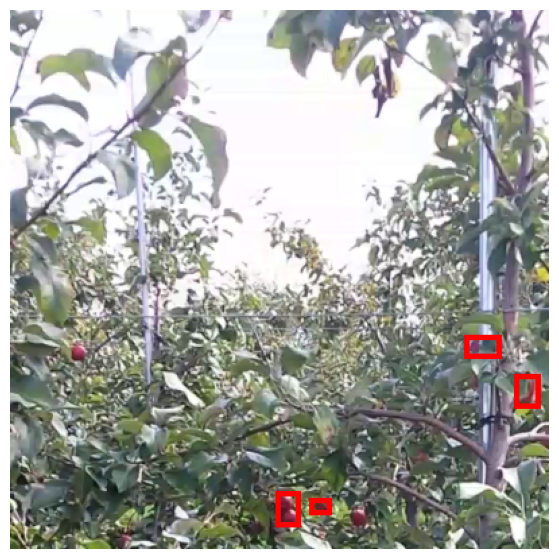

1it [00:00,  6.55it/s]

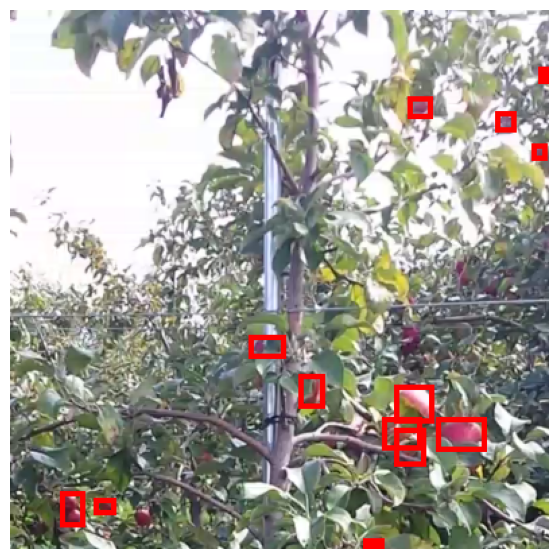

2it [00:00,  6.36it/s]

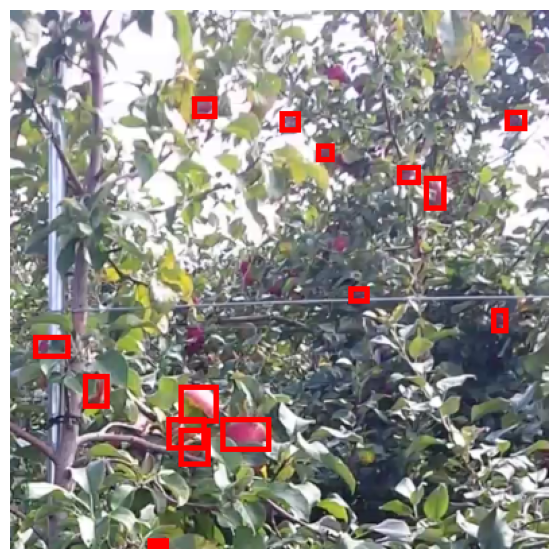

3it [00:00,  6.39it/s]

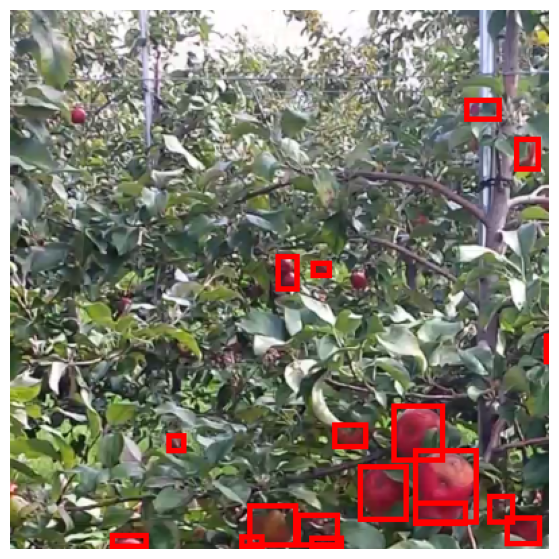

4it [00:00,  6.37it/s]

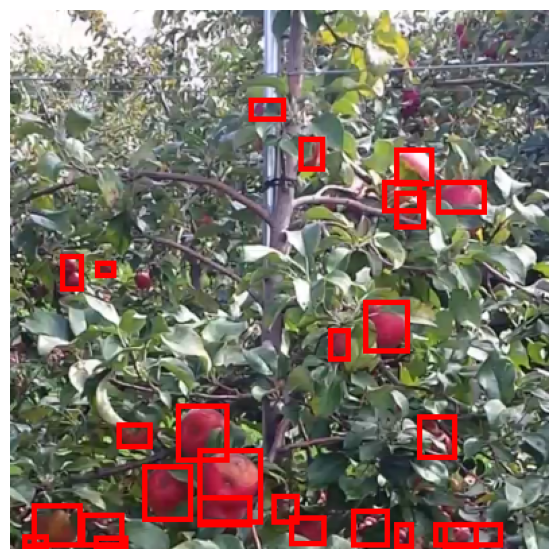

5it [00:00,  6.17it/s]

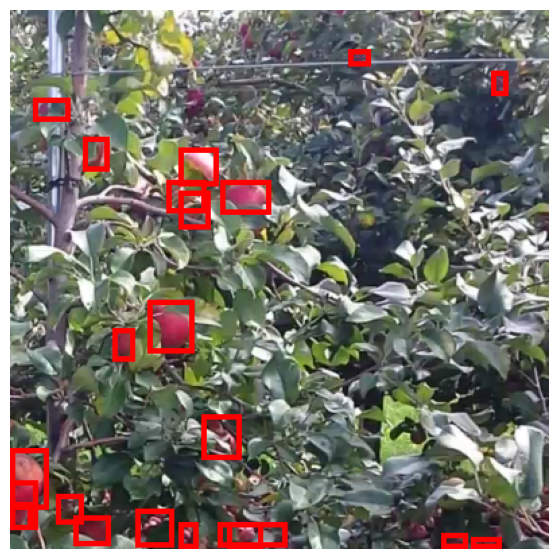

6it [00:00,  6.27it/s]

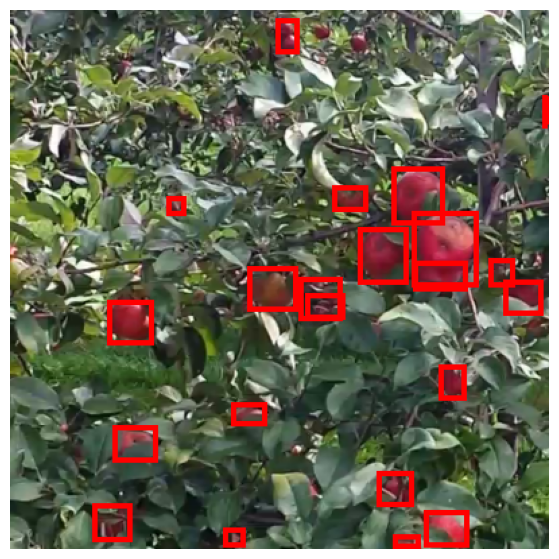

7it [00:01,  6.24it/s]

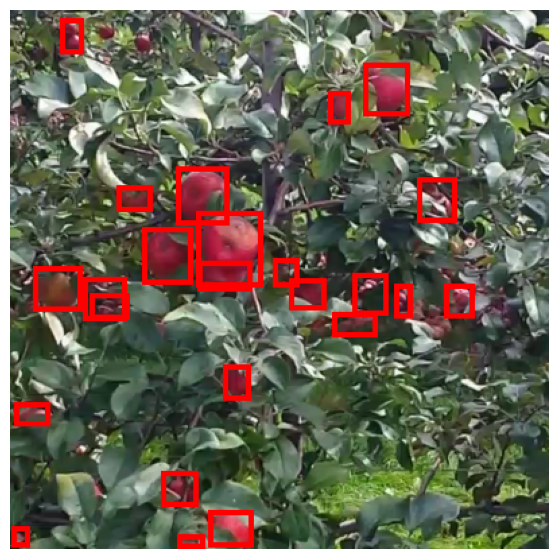

8it [00:01,  6.28it/s]

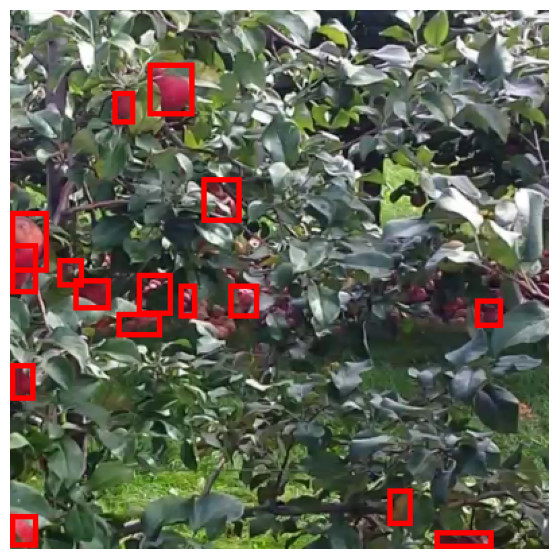

9it [00:01,  6.23it/s]

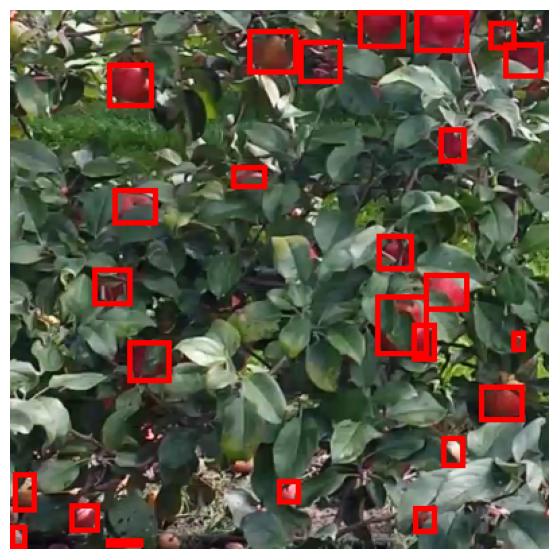

9it [00:01,  5.64it/s]


In [21]:
i = 0
for patch, pred in tqdm(zip(ds_patches.data_predict, predictions)):
#     cur_map = acc([pred], [gt])
    visualize_apples([(patch, pred)])
    i += 1
    
    if i >= 10:
        break

In [16]:
min_size = 10
nms_iou_thres = 0.3
merge_iou_thres = 0.4
# merge_iou_thres = 0.2

ds = ds_full.data_predict

preds = {}
predictions_batch = []
j = 0
for patches_preds in tqdm(predictions):
    predictions_batch.append(patches_preds)

    if len(predictions_batch) == total_patches:
        merged_target = merge_patch_detections(
            patchifier, 
            predictions_batch, 
            patches_shape, 
            min_size, 
            nms_iou_thres,
            merge_iou_thres,
        )

        img_name = ds.paths[j].name
        preds[img_name] = (merged_target, j)
        j += 1

        predictions_batch.clear()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5958/5958 [00:05<00:00, 1015.47it/s]


In [9]:
with open(GT_PATH) as f:
    gt_mapping = json.load(f)

In [10]:
annotations_by_id = defaultdict(list)
for annotation in gt_mapping["annotations"]:
    annotations_by_id[annotation["image_id"]].append(annotation["bbox"])

for img_id in annotations_by_id:
    annotations_by_id[img_id] = box_convert(torch.Tensor(annotations_by_id[img_id]).int(), in_fmt="xywh", out_fmt="xyxy")

In [17]:
acc = MeanAveragePrecision()

for j, image_info in tqdm(enumerate(gt_mapping["images"])):
    image_name = str(add_leading_zeros(Path(image_info["filename"])))
    cur_preds, i = preds[image_name]
    image = ds[i]

    img_id = image_info["id"]
    gt_boxes = annotations_by_id[img_id]
    gt = {
        "boxes": gt_boxes,
        "scores": torch.ones(gt_boxes.shape[0]).float(),
        "labels": torch.ones(gt_boxes.shape[0]).int()
    }
    cur_map = acc([cur_preds], [gt])
    print(cur_map)
    break
#     visualize_apples([(image, gt), (image, cur_preds)])

print(acc.compute())

0it [00:00, ?it/s]


{'map': tensor(0.3202), 'map_50': tensor(0.6151), 'map_75': tensor(0.2780), 'map_small': tensor(0.2638), 'map_medium': tensor(0.4943), 'map_large': tensor(-1.), 'mar_1': tensor(0.0161), 'mar_10': tensor(0.1548), 'mar_100': tensor(0.4484), 'mar_small': tensor(0.4095), 'mar_medium': tensor(0.5300), 'mar_large': tensor(-1.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.)}
{'map': tensor(0.3202), 'map_50': tensor(0.6151), 'map_75': tensor(0.2780), 'map_small': tensor(0.2638), 'map_medium': tensor(0.4943), 'map_large': tensor(-1.), 'mar_1': tensor(0.0161), 'mar_10': tensor(0.1548), 'mar_100': tensor(0.4484), 'mar_small': tensor(0.4095), 'mar_medium': tensor(0.5300), 'mar_large': tensor(-1.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.)}


In [ ]:
res = {
    'map': 0.3106, 
    'map_50': 0.5941, 
    'map_75': 0.2973, 
    'map_small': 0.1834, 
    'map_medium': 0.4036, 
    'map_large': 0.0198,
}

gt = {
    "map": 0.482,
    "map_50": 0.806,
    "map_75": 0.513,
    "map_small": 0.331,
    "map_medium": 0.64,
    "map_large": 0.937,
}